In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

import acquire 
import prepare 

 ----

### Project Goal:
The objective for this project is to identify drivers of overall churn of customers. Once those drivers are identified, they can be used for more focused marketing campaigns towards individuals who are seen as being at high risk of churning. 

----

### Acquiring the data:

Our data will be pulled from our Telco SQL database. In our SQL query, we joined the following relational databases together:
        
        - customers
        - internet_service_types
        - contract_types
        - payment_types
        
This will allow for the gathering of all relevant data into one database. Once the data is acquired for the first time, it will create a .csv file that can be pulled from the active directory.

An acquire.py file will also be created in order to perform the above steps by simply importing acquire and using the its local 'get_telco_data' function.

In [120]:
# Acquire the data using the acquire.py from the telco database
df = acquire.get_telco_data()
df.shape

Using cached csv


(7043, 24)

After acquiring and specifying the data we want, we see that it results in a DataFrame that has 7043 entries in 24 columns.

-----

### Preparing the data:
After acquisition, the prepare.py file can be used to call for 'train, validate, test'. With this call, a series of functions are used in order to do the following:

    - Drop duplicates that are not needed for analysis
    - Ensure that that 'total_charges' column is usable as a float
    - Encode data so that it is more suitable for machine learning
    - Rename columns to more user friendly terms
    - Split the data into proper train, validate, and test samples
    - Combine all actions into a single callable function

In [121]:
# Call the function to return train, validate,and test splits
train, validate, test = prepare.prep_telco(df)
train.shape, validate.shape, test.shape

((3943, 41), (1691, 41), (1409, 41))

After running our encoding and split, our dataset becomes wider at 41 columns. This is because we have to allow each usable column to break into binary so that we can use it for machine learning. The shape has decreased in size to 56% for the training data set, 24% for the validate dataset, and 20% for our test dataset. This helps us determine that our split was done correctly.

----

### Exploring the Data:

After running a correlation plot, we have a few questions about the driver that correlated the most with customers churn...

----

#### Question #1: Do churning customers pay the same amount on average as other customers?

#### Visualization:

<function matplotlib.pyplot.show(close=None, block=None)>

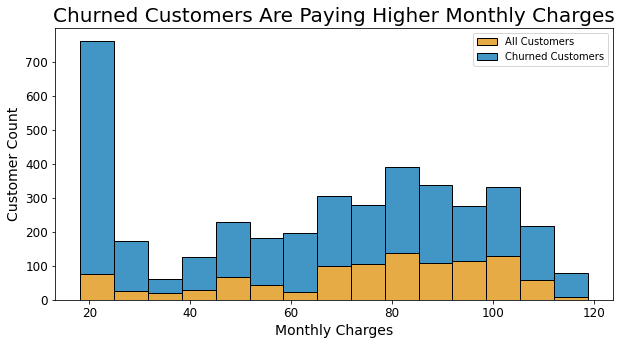

In [122]:
plt.figure(figsize= (10,5))
sns.histplot(train, 
             x=train.monthly_charges, 
             hue='churn', 
             multiple ='stack',
            legend = False,
            palette = 'colorblind')
plt.title('Churned Customers Are Paying Higher Monthly Charges', fontsize = 20)
plt.xlabel('Monthly Charges', fontsize = 14)
plt.ylabel('Customer Count', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(labels = ['All Customers', 'Churned Customers'])
plt.show

#### Statistical Testing - T-Test

#### Hypothesis:
  -  H0: Churning customers' monthly charges = Other customers' monthly charges.
  -  Ha: Churning customers' monthly charges != Other customers' monthly charges.

In [123]:
# Set te alpha for the test
alpha = .05
# Create variable names to input into our test
train_churn = train[train.churn==1].monthly_charges
overall_mean = train.monthly_charges.mean()
# Run the test to retrieve t and p
t,p = stats.ttest_1samp(train_churn, overall_mean)
# Run print statements depending on the tests outcome
if p/2 > alpha:
    print("We fail to reject the Null Hypothesis")
elif t < 0:
    print("We fail to reject the Null Hypothesis")
else:
    print("We reject the Null Hypothesis")

We reject the Null Hypothesis


#### Answer to question # 1:

Visualizing the issue makes it obvious that churning customers are paying much more than our typical customers. This understanding is enforced by our statistical analyisis considering we reject our null hypothesis that states they pay the same on average. 

----

#### Question #2: In what year do most customers churn?

#### Visualization:

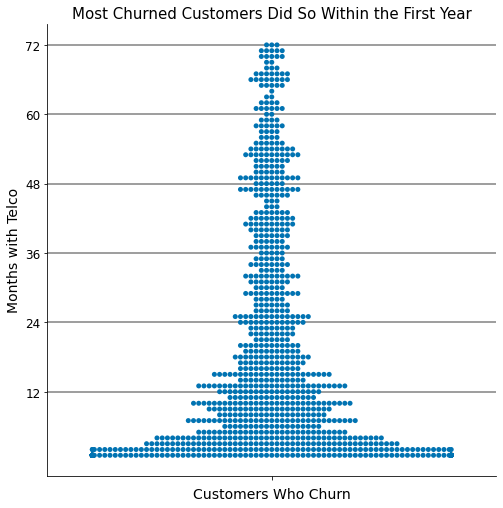

In [124]:
chrn = sns.catplot( x= 'churn', y = 'tenure',
            kind = 'swarm', palette = 'colorblind', 
            size = 7, aspect = 1,
            data = train[train.churn == 1])
plt.title('Most Churned Customers Did So Within the First Year', fontsize = 15)
plt.xlabel('Customers Who Churn', fontsize = 14)
plt.ylabel('Months with Telco', fontsize = 14)
plt.yticks([12,24,36,48,60,72])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
chrn.set_xticklabels([''])
plt.axhline(y=12, linestyle = '-', color = 'grey')
plt.axhline(y=24, linestyle = '-', color = 'grey')
plt.axhline(y=36, linestyle = '-', color = 'grey')
plt.axhline(y=48, linestyle = '-', color = 'grey')
plt.axhline(y=60, linestyle = '-', color = 'grey')
plt.axhline(y=72, linestyle = '-', color = 'grey')

#### Answer to Question #2:

The above visual shows the first year is by far the most likely year that customers churn.

----

#### Question #3: Are  customer churn and internet service types related?

#### Visualization:

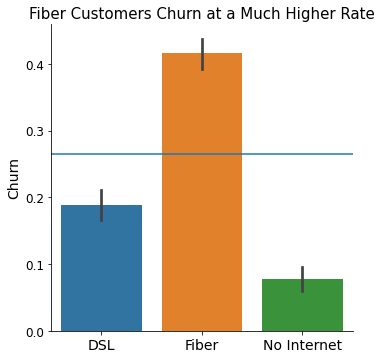

In [125]:
avg_churn = train.churn.mean()
internet = sns.catplot(data=train, 
            x='internet_type', 
            y='churn', 
            kind='bar',
            )
plt.title('Fiber Customers Churn at a Much Higher Rate', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Churn',fontsize = 14)
plt.xlabel('')
plt.axhline(avg_churn, label='overall churn rate')
internet.set_xticklabels(['DSL', 'Fiber', 'No Internet'])
plt.show()

#### Statistical Testing - Chi^2

#### Hypothesis:
  -  H0: Internet service type is independent of customer churn
  -  Ha: Internet service type is not independent of customer churn

In [126]:
# Set the alpha for the test
alpha = .01
# Create a crosstab for internet type and churn
observed = pd.crosstab(train.churn, train.internet_service_type)
# Run the chi^2 test to retrieve the following
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('=============================================\nExpected\n')
print(expected)
print('=============================================\n')
print(f'chi^2 = {chi2:.2f}')
print(f'p     = {p:.2f}')
if p<alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Observed

[[1095 1019  783]
 [ 254  726   66]]
Expected

[[ 991.13695156 1282.08597515  623.77707329]
 [ 357.86304844  462.91402485  225.22292671]]

chi^2 = 397.74
p     = 0.00
We reject the null hypothesis.


#### Answer to question # 3:

With the use of our visualization and chi^2 test, we can reject the null hypothesis. This means we can say with a 99% accuracy that internet service type and churn are not independent of each other.

----

#### Question #4: Do month-to-month customers really churn at a higher rate than all others?

#### Visualization:

Text(0, 0.5, 'Customer Count')

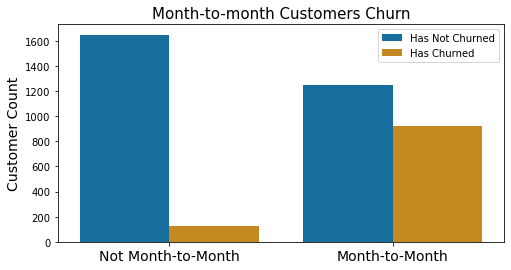

In [127]:
churn_df = pd.DataFrame({'Yes':train.churn.sum(),
                         'No':(train.churn == 0).sum()}, 
                         index = ['Churn']).T
labels = churn_df.index
plt.figure(figsize = (8, 4))
mtm = sns.countplot(x='month_to_month', 
              hue = 'churn', 
              palette = 'colorblind', 
              data = train)
plt.title('Month-to-month Customers Churn', fontsize = 15)
plt.legend(labels = ['Has Not Churned', 'Has Churned'])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
mtm.set_xticklabels(['Not Month-to-Month','Month-to-Month'])
plt.xlabel('', fontsize = 14)
plt.ylabel('Customer Count', fontsize = 14)

#### Answer to #4:

Based on the graphic above, month-to-month contract churn at a much higher rate than other contracts.

----

### Modeling the data:

In [128]:
# Define features for our model
features =['monthly_charges',
         'month_to_month',
         'tenure',
         'fiber_int',
         'dsl_int',
         'no_internet',
         'bt_auto',
         'cc_auto',
         'elecc_nonauto',
         'mailc_nonauto',
         'senior_citizen',
         'paperless_billing']
# Define target
target = 'churn'
# create x and y for train, validate, and test sets 
x_train = train[features]
y_train = train[target]
x_validate = validate[features]
y_validate = validate[target]
x_test = test[features]
y_test = test[target]

#### Set a baseline:

In [129]:
# Obtain the mode for the target to find most occuring.
baseline = y_train.mode()
# See when the train and prediction matches up. 
matches_baseline_prediction = (y_train == 0)
# Match prediction against the train data and take the 
# mean of how many times it occurs. 
baseline_accuracy = matches_baseline_prediction.mean()

print(f'The Baseline Accuracy is {baseline_accuracy:.2%}')

The Baseline Accuracy is 73.47%


#### Decision Tree:

In [130]:
#Create the model
tree = DecisionTreeClassifier(max_depth=7, random_state=123)
# Fit the model
tree.fit(x_train, y_train)
# Evaluate the model
# Accuracy on train for the Decision Tree:
print(f'Accuracy of Decision Tree Classifier on the training set is {(tree.score(x_train, y_train)):.2%}')
# Accuracy on validate for the Decision Tree:
print(f'Accuracy of Decision Tree Classifier on the validate set is {(tree.score(x_validate, y_validate)):.2%}')

Accuracy of Decision Tree Classifier on the training set is 82.42%
Accuracy of Decision Tree Classifier on the validate set is 79.24%


#### Random Forest Model:

In [131]:
# Create the model
rf = RandomForestClassifier(max_depth=10,min_samples_leaf=10,random_state=1349)
# Fit the model
rf.fit(x_train, y_train)
# Accuracy on train for the Random Forest:
print(f'Accuracy of Random Forest on the training set is {(rf.score(x_train, y_train)):.2%}')
# Accuracy on validate for the Random Forest:
print(f'Accuracy of Random Forest on the validate set is {(rf.score(x_validate, y_validate)):.2%}')

Accuracy of Random Forest on the training set is 82.45%
Accuracy of Random Forest on the validate set is 79.66%


#### K's Nearest Neighbors:

In [132]:
# Create the model
knn = KNeighborsClassifier(n_neighbors=5)
# Fit the model
knn.fit(x_train,y_train)
# Accuracy on train for  KNN:
print(f'Accuracy of KNN on the training set is {(knn.score(x_train, y_train)):.2%}')
# Accuracy on validate for KNN:
print(f'Accuracy of KNN on the validate set is {(knn.score(x_validate, y_validate)):.2%}')

Accuracy of KNN on the training set is 83.69%
Accuracy of KNN on the validate set is 77.29%


#### Logistical Regression:

In [133]:
# Create the model
logit = LogisticRegression(C=1, random_state=123)
# Fit the model
logit.fit(x_train, y_train)
# Accuracy on train for  KNN:
print(f'Accuracy of Logistic Regression on the training set is {(logit.score(x_train, y_train)):.2%}')
# Accuracy on validate for KNN:
print(f'Accuracy of Logistic Regression on the validate set is {(logit.score(x_validate, y_validate)):.2%}')

Accuracy of Logistic Regression on the training set is 79.61%
Accuracy of Logistic Regression on the validate set is 79.42%


----

#### Assess what model is 'best' to run on the  test dataset

While Decision Tree, Random Forest, and Logistical Regression models came in within half a percent, the Random Forest model edges the others out with a 79.66% accuracy score on the validate dataset. This model beats our baseline by 6.19%.

----

#### Running the Random Forest model on the test dataset.

In [134]:
# Create predictions to use against the test dataset
y_pred = rf.predict(x_test)
# Create a DataFrame to show the modeled test data's metrics
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.845662,0.894686,0.869484,1035.000000
1,0.652866,0.548128,0.595930,374.000000
accuracy,0.802697,0.802697,0.802697,0.802697
macro avg,0.749264,0.721407,0.732707,1409.000000
weighted avg,0.794487,0.802697,0.796873,1409.000000


Our test classification report shows that we can determine whether or not a customer will churn with 80% accuracy. It should be noted that this model only results in a very low recall of 55%. This means that only about 55% of customers who will churn will be identified as such.

----

### Key Takeaways:

- Churning customers are paying higher monthly charges versus other non-churning customers.

- Most customer churn happens within the first year of tenure.

- Internet service type is related to customer churn.

- Month-to-month customers churn at a much higher rate versus other contract types.

### Recommendations

- Create a marketing program that directly influences these categories
- Decrease the price increase on month-to-month contracts in order to influence attrition positively.
- Offer incentivizaton programs that place customers into longer term contracts.
- Look for ways to bring a savings to Fiber customers in order to keep them aboard.

### Next Steps:

- In the future we will be able to use this model in order to predict with 80% accuracy whether or not a customer will churn. Knowing this information will allow us to better focus resources and marketing campaigns in order to reduce customer churn in the future and better effect our bottom line.
- A further dive into the data with more time allowed will help in improving the accuracy of our model by identifying more conclusive and impactful drivers. 
